In [1]:
import ccxt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

In [2]:
# ------------------------------
# 1. Fetch Binance 1h OHLCV data
# ------------------------------
exchange = ccxt.binance()
symbol = "BTC/USDT"
timeframe = "1h"

# Calculate start timestamp for 3 months ago
since = int((datetime.utcnow() - timedelta(days=90)).timestamp() * 1000)

ohlcv = exchange.fetch_ohlcv(symbol, timeframe=timeframe, since=since)
df = pd.DataFrame(ohlcv, columns=["Time", "Open", "High", "Low", "Close", "Volume"])
df['Time'] = pd.to_datetime(df['Time'], unit='ms')
df.set_index('Time', inplace=True)


/tmp/ipykernel_7369/780135676.py:9: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  since = int((datetime.utcnow() - timedelta(days=90)).timestamp() * 1000)


In [4]:
# ------------------------------
# 2. Compute TSI
# ------------------------------
def compute_tsi(close, r1=25, r2=13):
    delta = close.diff()
    ema1 = delta.ewm(span=r1, adjust=False).mean()
    ema2 = ema1.ewm(span=r2, adjust=False).mean()

    abs_delta = delta.abs()
    abs_ema1 = abs_delta.ewm(span=r1, adjust=False).mean()
    abs_ema2 = abs_ema1.ewm(span=r2, adjust=False).mean()

    tsi = 100 * (ema2 / abs_ema2)
    return tsi

df['TSI'] = compute_tsi(df['Close'])


In [5]:
# ------------------------------
# 3. Detect Swing Highs / Lows
# ------------------------------
lookback = 5  # ±5 candles

def detect_swings(prices, highs, lows, lookback=5):
    labels = np.zeros(len(prices))
    for i in range(lookback, len(prices)-lookback):
        # Swing High → Downtrend reversal
        if highs[i] == max(highs[i-lookback:i+lookback+1]):
            labels[i] = -1
        # Swing Low → Uptrend reversal
        elif lows[i] == min(lows[i-lookback:i+lookback+1]):
            labels[i] = 1
    return labels

df['Label'] = detect_swings(df['Close'], df['High'], df['Low'], lookback=lookback)


/tmp/ipykernel_7369/2801216820.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if highs[i] == max(highs[i-lookback:i+lookback+1]):
/tmp/ipykernel_7369/2801216820.py:13: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  elif lows[i] == min(lows[i-lookback:i+lookback+1]):


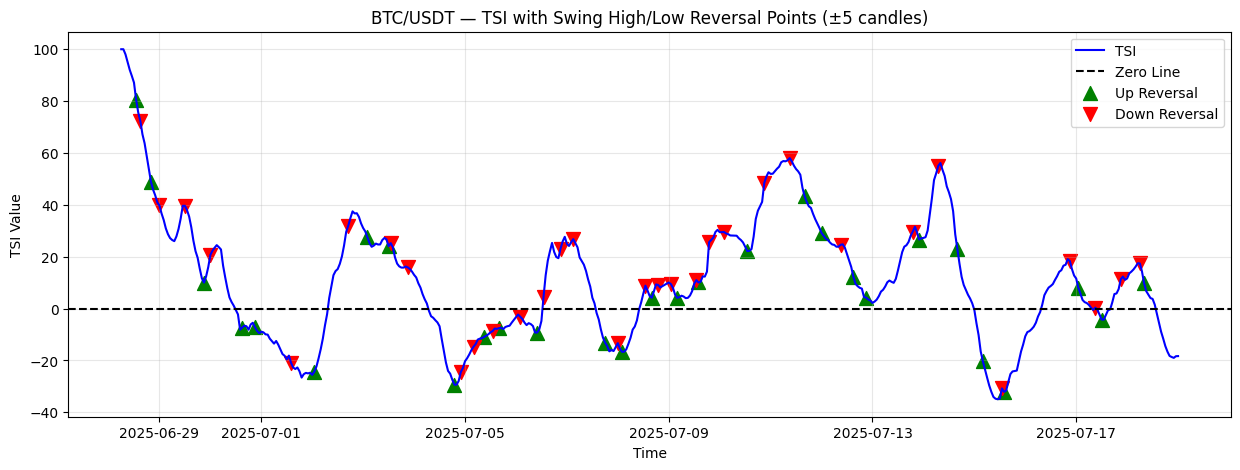

In [6]:
# ------------------------------
# 4. Plot TSI with Swing Reversals
# ------------------------------
plt.figure(figsize=(15,5))
plt.plot(df.index, df['TSI'], color='blue', linewidth=1.5, label='TSI')

# Zero line
plt.axhline(0, color='black', linestyle='--', label='Zero Line')

# Reversal points
plt.scatter(df.index[df['Label']==1], df['TSI'][df['Label']==1],
            marker='^', color='green', s=100, label='Up Reversal')
plt.scatter(df.index[df['Label']==-1], df['TSI'][df['Label']==-1],
            marker='v', color='red', s=100, label='Down Reversal')

plt.title(f"{symbol} — TSI with Swing High/Low Reversal Points (±{lookback} candles)")
plt.xlabel("Time")
plt.ylabel("TSI Value")
plt.legend()
plt.grid(alpha=0.3)
plt.show()